# Extrapolation: HVAC Units

### Importing Packages

In [88]:
import pandas as pd
import numpy as np

import patsy                           # provides a syntax for specifying models  
import statsmodels.api as sm           # provides statistical models like ols, gmm, anova, etc...
import statsmodels.formula.api as smf  # provides a way to directly spec models from formulas

from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

### Importing Simulation and HVAC Data

In [146]:
# Import simulation data
simdata = pd.read_csv("MidPackage_RetrofitResults.csv")
# Import HVAC data
hvac = pd.read_csv("LA_HVAC_results.csv")
print('Pre-merge:','\n',simdata.shape, '\n', hvac.shape)

# Merge dataframes
merged = pd.merge(simdata, hvac, left_on="ubid", right_on="LA_bid")
print("Post-merge:","\n", merged.shape)
#merged.head()

# Selecting only buidlings from Simulation
merged = merged[merged['retrofit package name'] == "ECM Package 1"]

# Renaming some columns
merged = merged.rename(columns={"year built (year)": "year_built", 
                                "total floor area (m2)": "floor_area", 
                                "baseline annual site energy use intensity (kWh/m2)": "site_eui",
                                "baseline annual water for water systems (m3/m2)": "annual_water"})

# Changing units
merged["annual_water"] = merged["annual_water"]*merged["floor_area"]
merged["annual_water"] = merged["annual_water"]*264.172
merged["floor_area"] = merged["floor_area"]*10.7639
merged["annual_water"] = merged["annual_water"]/merged["floor_area"]

Pre-merge: 
 (486, 105) 
 (243, 5)
Post-merge: 
 (486, 110)


### Importing EBEWE Data

In [167]:
EBEWE_buildings = pd.read_csv("Building_Data.csv") 
EBEWE_buildings = EBEWE_buildings.replace('Not Available',np.NaN)
EBEWE_buildings = EBEWE_buildings.replace('',np.NaN)
EBEWE_buildings = EBEWE_buildings.replace(' ',np.NaN)

# Keeping only unqiue buidling IDs
unique = EBEWE_buildings.drop_duplicates('BUILDING.ID') 

# Renaming some columns
unique = unique.rename(columns={"YEAR.BUILT": "year_built", 
                                "GROSS.BUILDING.FLOOR.AREA": "floor_area", 
                                "SITE.EUI": "site_eui",
                                "TOTAL.WATER.USE": "annual_water"})
# Changing units
unique["annual_water"] = (unique["annual_water"]*1000)/unique['floor_area']

unique.shape

(11724, 36)

## 1. Multi-Family

In [148]:
# Selecting only multi-family housing
regdata1 = merged[(merged["building type"] == "Multi Family House")]
regdata1.shape

(118, 110)

In [149]:
regdata1 = regdata1[["number_of_HVAC_units","year_built","floor_area","site_eui", "annual_water"]]

# Adding year_built indicators
regdata1["seventies"] = 0
regdata1.loc[(regdata1['year_built'] < 1980), 'seventies'] = 1
regdata1["eighties"] = 0
regdata1.loc[(regdata1['year_built'] >= 1980) & (regdata1['year_built'] < 1990), 'eighties'] = 1
regdata1["nineties"] = 0
regdata1.loc[(regdata1['year_built'] >= 1990) & (regdata1['year_built'] < 2000), 'ninties'] = 1
regdata1["twothou"] = 0
regdata1.loc[(regdata1['year_built'] > 2000), 'twothou'] = 1

# Scaling the data
scaler = MinMaxScaler()
scaler.fit(regdata1[["floor_area","site_eui","annual_water"]])
regdata1[["floor_area","site_eui","annual_water"]] = scaler.transform(regdata1[["floor_area","site_eui","annual_water"]])

regdata1.head()

,number_of_HVAC_units,year_built,floor_area,site_eui,annual_water,seventies,eighties,nineties,ninties,twothou
3,48,1971,0.099798,0.463820,0.165269,1,0,0,NaN,0
9,64,1969,0.096850,0.475176,0.217759,1,0,0,NaN,0
11,75,1971,0.156731,0.351933,0.214793,1,0,0,NaN,0
23,39,1986,0.058442,0.405358,0.178111,0,1,0,NaN,0
25,15,1986,0.014625,0.653063,0.409638,0,1,0,NaN,0


### Regression Model

In [175]:
# Regression model
res1 = smf.ols('number_of_HVAC_units ~ floor_area + np.power(floor_area,2) -1', data=regdata1).fit()
print(res1.summary())

                                  OLS Regression Results                                 
Dep. Variable:     number_of_HVAC_units   R-squared (uncentered):                   0.945
Model:                              OLS   Adj. R-squared (uncentered):              0.944
Method:                   Least Squares   F-statistic:                              994.8
Date:                  Wed, 24 Mar 2021   Prob (F-statistic):                    9.59e-74
Time:                          17:44:20   Log-Likelihood:                         -569.57
No. Observations:                   118   AIC:                                      1143.
Df Residuals:                       116   BIC:                                      1149.
Df Model:                             2                                                  
Covariance Type:              nonrobust                                                  
                              coef    std err          t      P>|t|      [0.025      0.975]
--------

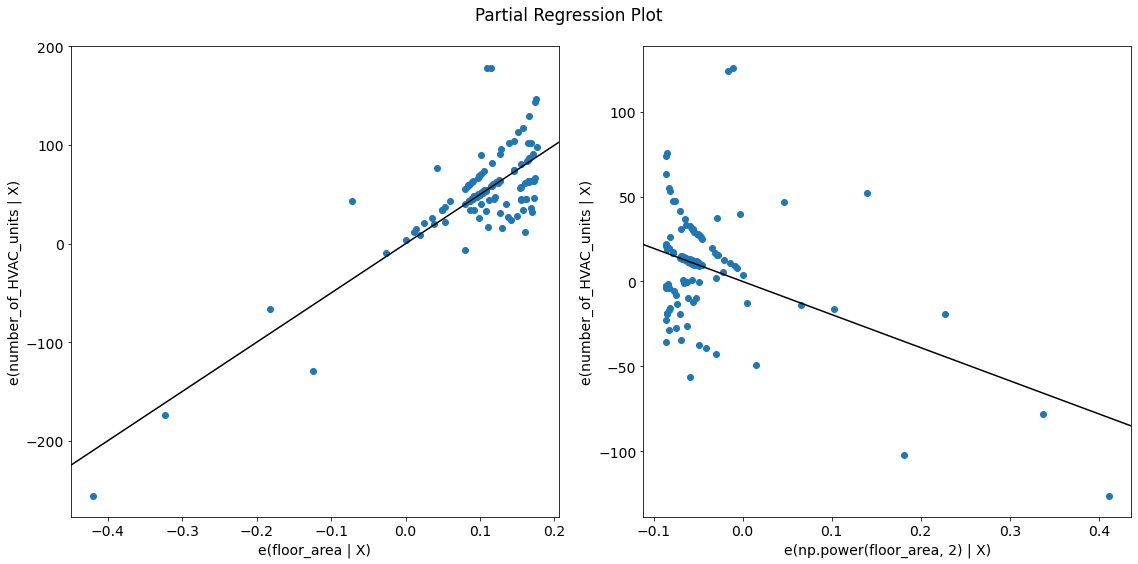

In [176]:
plt.rc("figure", figsize=(16,8))
plt.rc("font", size=14)

fig = sm.graphics.plot_partregress_grid(res1)
fig.tight_layout(pad=1.0)

In [ ]:
#fig = plt.figure(figsize=(12,8))
#fig = sm.graphics.plot_regress_exog(res, 'floor_area', fig=fig)

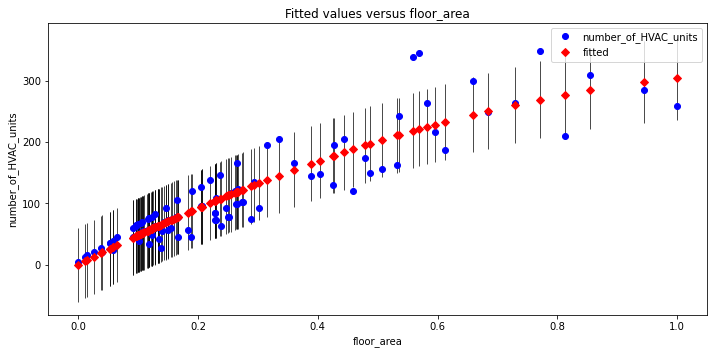

In [177]:
plt.rc("figure", figsize=(10,5))
plt.rc("font", size=10)
fig = sm.graphics.plot_fit(res1, "floor_area")
fig.tight_layout(pad=1.0)

### Extrapolating to the EBEWE Open Data

In [178]:
# Select only medium multi-family 
multi_medium = unique[(unique["PROPERTY.TYPE"]=="Multifamily Housing")]
#(unique["LADBS.Building.Category"]=="50,000 to 99,999")
#multi_medium_selection = multi_medium[(multi_medium["YEAR.BUILT"] < 1990) & 
#                                      (multi_medium["YEAR.BUILT"] > 1970) & 
#                                      (multi_medium["GROSS.BUILDING.FLOOR.AREA"] > 50000) & 
#                                      (multi_medium["GROSS.BUILDING.FLOOR.AREA"] < 100000)]
multi_medium.shape

(2146, 36)

In [182]:
# Selecting regression x_variables
xvariables = multi_medium[["BUILDING.ID", "year_built", "floor_area"]]

# Scale data
scaler = MinMaxScaler()
scaler.fit(xvariables[["floor_area"]])
xvariables[["floor_area"]] = scaler.transform(xvariables[["floor_area"]])
xvariables = xvariables.drop(columns=["year_built"])

In [183]:
# Predicting # of HVAC Units
xvariables['predicted_HVAC_units'] = res1.predict(xvariables[["floor_area"]])
pd.set_option('display.max_rows', 500)
xvariables

,BUILDING.ID,floor_area,predicted_HVAC_units
1,474608916272,0.005545,2.761667
5,471068915912,0.014394,7.144520
32,475197914051,0.008329,4.143781
34,474880915329,0.007088,3.528298
42,473333914129,0.009724,4.835461
...,...,...,...
40274,383291888609,0.008183,4.071422
40278,440648884069,0.011035,5.484266
40372,999000000227,0.043070,21.136338
40522,403609884896,0.009939,4.941690


## 2. Offices

In [184]:
# Selecting only multi-family housing
regdata2 = merged[(merged["building type"] == "Small Office") | 
                  (merged["building type"] == "Medium Office") | 
                  (merged["building type"] == "Large Office")]
regdata2.shape

(117, 110)

In [185]:
regdata2 = regdata2[["number_of_HVAC_units","year_built","floor_area","site_eui", "annual_water"]]

# Adding year_built indicators
# Adding year_built indicators
regdata2["post1970"] = 0
regdata2.loc[(regdata2['year_built'] > 1970), 'post1970'] = 1

# Scaling the data
scaler = MinMaxScaler()
scaler.fit(regdata2[["floor_area","site_eui","annual_water"]])
regdata2[["floor_area","site_eui","annual_water"]] = scaler.transform(regdata2[["floor_area","site_eui","annual_water"]])

regdata2.head()

,number_of_HVAC_units,year_built,floor_area,site_eui,annual_water,post1970
1,1,1984,0.129802,0.424684,0.804878,1
5,1,1981,0.059266,0.513085,0.865854,1
7,3,1984,0.026750,0.078551,0.780488,1
13,1,1980,0.046135,0.555209,0.853659,1
15,3,1985,0.039085,0.069488,0.829268,1


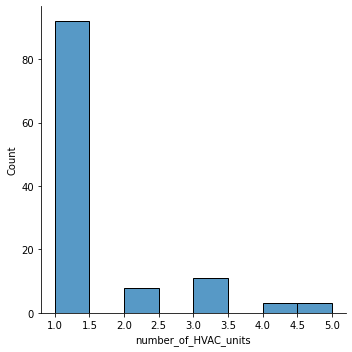

In [186]:
import seaborn as sns
sns.displot(regdata2, x="number_of_HVAC_units")

### Regression Model

In [205]:
# Regression model
res2 = smf.ols('number_of_HVAC_units ~ site_eui + annual_water + post1970 -1', data=regdata2).fit()
print(res2.summary())

                                  OLS Regression Results                                 
Dep. Variable:     number_of_HVAC_units   R-squared (uncentered):                   0.748
Model:                              OLS   Adj. R-squared (uncentered):              0.741
Method:                   Least Squares   F-statistic:                              112.5
Date:                  Wed, 24 Mar 2021   Prob (F-statistic):                    6.30e-34
Time:                          19:04:36   Log-Likelihood:                         -148.93
No. Observations:                   117   AIC:                                      303.9
Df Residuals:                       114   BIC:                                      312.1
Df Model:                             3                                                  
Covariance Type:              nonrobust                                                  
                   coef    std err          t      P>|t|      [0.025      0.975]
-------------------

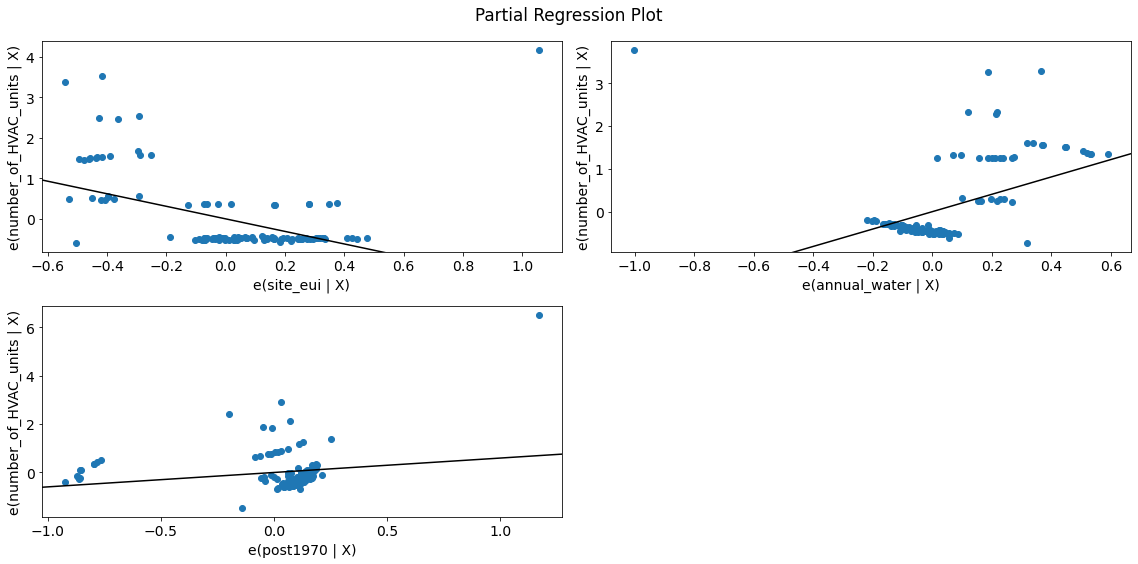

In [188]:
plt.rc("figure", figsize=(16,8))
plt.rc("font", size=14)

fig = sm.graphics.plot_partregress_grid(res2)
fig.tight_layout(pad=1.0)

### Extrapolating to the EBEWE Open Data

In [189]:
# Select only medium multi-family 
e_offices = unique[(unique["PROPERTY.TYPE"]=="Office")]
#(unique["LADBS.Building.Category"]=="50,000 to 99,999")
#e_offices = e_offices[(e_offices["YEAR.BUILT"] < 1990) & 
#                                      (e_offices["YEAR.BUILT"] > 1970) & 
#                                      (e_offices["GROSS.BUILDING.FLOOR.AREA"] > 50000) & 
#                                      (e_offices["GROSS.BUILDING.FLOOR.AREA"] < 100000)]
e_offices.shape

(556, 36)

In [190]:
# Selecting regression x_variables
xvariables = e_offices[["BUILDING.ID", "year_built", "floor_area", "annual_water", "site_eui"]]

# Add indicator variables as abvove
xvariables["post1970"] = 0
xvariables.loc[(xvariables['year_built'] > 1970), 'post1970'] = 1

# Scale data
scaler = MinMaxScaler()
scaler.fit(xvariables[["floor_area","site_eui","annual_water"]])
xvariables[["floor_area","site_eui","annual_water"]] = scaler.transform(xvariables[["floor_area","site_eui","annual_water"]])
xvariables = xvariables.drop(columns=["year_built"])

In [192]:
# Predicting # of HVAC Units
xvariables['predicted_HVAC_units'] = res2.predict(xvariables[["site_eui","annual_water", "post1970"]])
pd.set_option('display.max_rows', 100)
xvariables

,BUILDING.ID,floor_area,annual_water,site_eui,post1970,predicted_HVAC_units
103,477465912352,0.008327,0.000943,0.027955,1,0.554401
318,438800926181,0.008968,0.004604,0.036258,1,0.548963
1015,423161933116,0.023508,0.001992,0.039441,1,0.538729
1119,417566936449,0.006854,0.005814,0.090091,1,0.467992
1323,419932921789,0.011469,0.004636,0.063521,1,0.506777
...,...,...,...,...,...,...
39936,420354896258,0.009356,0.016723,1.000000,1,-0.919957
40065,420191907323,0.005604,0.087112,0.339330,1,0.246733
40114,490080842381,0.148969,0.004580,0.064351,1,0.505379
40196,465050853626,0.013303,0.003115,0.143371,1,0.379947


# 3. Retail

In [193]:
# Selecting only multi-family housing
retail = merged[(merged["building type"] == "Small Retail") | 
                 (merged["building type"] == "Medium Retail") | 
                 (merged["building type"] == "Large Retail")]
retail.shape

(8, 110)

In [195]:
regdata3 = retail[["number_of_HVAC_units","year_built","floor_area","site_eui", "annual_water"]]

# Adding year_built indicators
# Adding year_built indicators
regdata3["post1970"] = 0
regdata3.loc[(regdata3['year_built'] > 1970), 'post1970'] = 1

# Scaling the data
scaler = MinMaxScaler()
scaler.fit(regdata3[["floor_area","site_eui","annual_water"]])
regdata3[["floor_area","site_eui","annual_water"]] = scaler.transform(regdata3[["floor_area","site_eui","annual_water"]])

regdata3.head()

,number_of_HVAC_units,year_built,floor_area,site_eui,annual_water,post1970
109,1,1989,0.812663,0.068204,0.999919,1
207,2,1969,0.002166,1.000000,0.000808,0
255,2,1989,0.450261,0.000000,0.999758,1
293,2,1988,0.000000,0.802666,0.000000,1
353,1,1966,0.210197,0.330205,1.000000,0


In [203]:
# Regression model
res3 = smf.ols('number_of_HVAC_units ~ site_eui + annual_water -1', data=regdata3).fit()
print(res3.summary())

                                  OLS Regression Results                                 
Dep. Variable:     number_of_HVAC_units   R-squared (uncentered):                   0.765
Model:                              OLS   Adj. R-squared (uncentered):              0.687
Method:                   Least Squares   F-statistic:                              9.781
Date:                  Wed, 24 Mar 2021   Prob (F-statistic):                      0.0129
Time:                          17:49:14   Log-Likelihood:                         -9.2191
No. Observations:                     8   AIC:                                      22.44
Df Residuals:                         6   BIC:                                      22.60
Df Model:                             2                                                  
Covariance Type:              nonrobust                                                  
                   coef    std err          t      P>|t|      [0.025      0.975]
-------------------

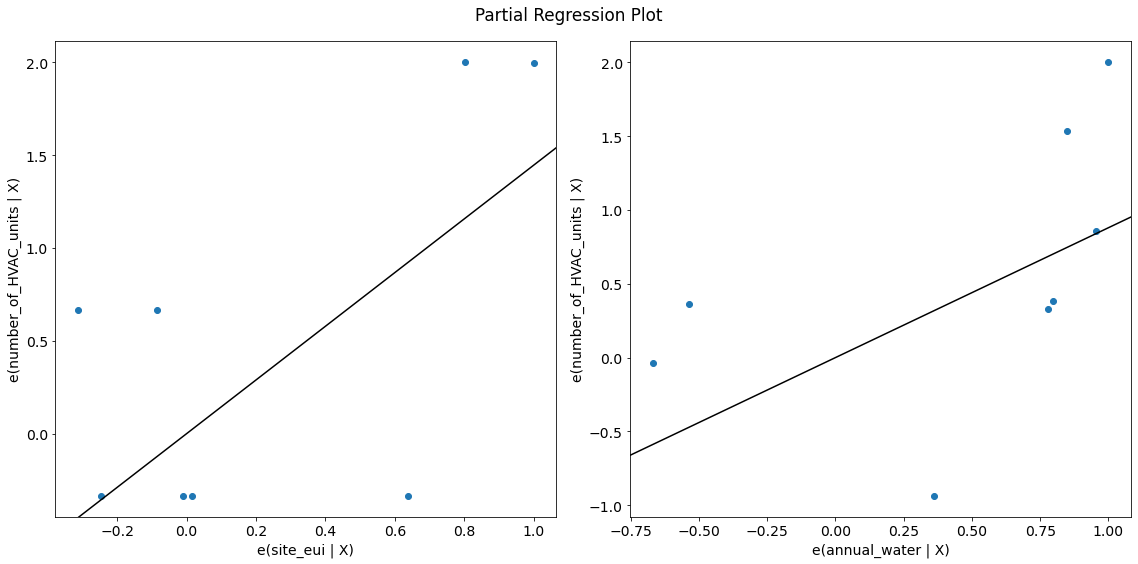

In [204]:
plt.rc("figure", figsize=(16,8))
plt.rc("font", size=14)

fig = sm.graphics.plot_partregress_grid(res3)
fig.tight_layout(pad=1.0)

In [207]:
# Select only medium multi-family 
e_retail = unique[(unique["PROPERTY.TYPE"]=="Retail")]
#(unique["LADBS.Building.Category"]=="50,000 to 99,999")
#e_offices = e_offices[(e_offices["YEAR.BUILT"] < 1990) & 
#                                      (e_offices["YEAR.BUILT"] > 1970) & 
#                                      (e_offices["GROSS.BUILDING.FLOOR.AREA"] > 50000) & 
#                                      (e_offices["GROSS.BUILDING.FLOOR.AREA"] < 100000)]
e_retail.shape

(0, 36)

## kNN Imputation

In [109]:
#simdata = merged[["number_of_HVAC_units","year_built","floor_area","site_eui", "annual_water"]]
x = regdata.drop(columns=["number_of_HVAC_units", "year_built"])
y = regdata["number_of_HVAC_units"]

In [110]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=100)
neigh.fit(x,y)

KNeighborsClassifier(n_neighbors=100)

In [113]:
xvariables.dropna()['predicted_HVAC_units'] = neigh.predict(xvariables.dropna())

In [115]:
xvariables[0:100]

,floor_area,annual_water,site_eui,post1980
103,0.008327,0.000943,0.027955,0
318,0.008968,0.004604,0.036258,1
1015,0.023508,0.001992,0.039441,1
1119,0.006854,0.005814,0.090091,1
1323,0.011469,0.004636,0.063521,1
1350,0.006198,NaN,NaN,1
1410,0.008128,0.001068,0.047883,1
1441,0.008120,0.002620,0.065181,1
1443,0.004818,0.005893,0.049267,1
1565,0.022363,0.006083,0.023941,0
